In [1]:
# Core imports
import os
import getpass
from uuid import uuid4
from typing import Annotated, TypedDict

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [2]:
# Set API Keys
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [3]:
# Optional: LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Agent Memory - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - Agent Memory - a380b057


In [4]:
# Initialize LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test the connection
response = llm.invoke("Say 'Memory systems ready!' in exactly those words.")
print(response.content)

Memory systems ready!


## Architecture Diagram




                         User Input
                         { message, user_id, feedback (optional) }
                                      │
                                      ▼
                            ┌─────────────────┐
                            │     ROUTER      │
                            │─────────────────│
                            │ Reads: Profile  │
                            │ Routes to one   │
                            │ specialist      │
                            └────────┬────────┘
                                     │
                   ┌─────────────────┼─────────────────┐
                   ▼                 ▼                 ▼
            ┌──────────┐      ┌──────────┐      ┌──────────┐
            │ EXERCISE │      │ NUTRITION│      │  SLEEP   │
            │SPECIALIST│      │SPECIALIST│      │SPECIALIST│
            │──────────│      │──────────│      │──────────│
            │ Reads:   │      │ Reads:   │      │ Reads:   │
            │ -Profile │      │ -Profile │      │ -Profile │
            │ -Knowledge│     │ -Knowledge│     │ -Knowledge│
            │ -Own Inst│      │ -Own Inst│      │ -Own Inst│
            │ -All Eps │      │ -All Eps │      │ -All Eps │
            └────┬─────┘      └────┬─────┘      └────┬─────┘
                 │                 │                 │
                 └─────────────────┼─────────────────┘
                                   │
                                   ▼
                           [has feedback?]
                             /         \
                           yes          no
                           /             \
                          ▼               ▼
                   ┌────────────┐      ┌─────┐
                   │ REFLECTION │      │ END │
                   │────────────│      └─────┘
                   │ Updates 1  │
                   │ or all     │
                   │ agents'    │
                   │ instructions│
                   └─────┬──────┘
                         │
                         ▼
                       END


## Memory namespaces

```
SHARED
├── (user_id, "profile")         # User goals, conditions
└── ("wellness", "knowledge")    # RAG knowledge base

PER-AGENT
├── ("exercise_agent", "instructions")   # Procedural memory
├── ("exercise_agent", "episodes")       # Episodic memory
├── ("nutrition_agent", "instructions")
├── ("nutrition_agent", "episodes")
├── ("sleep_agent", "instructions")
└── ("sleep_agent", "episodes")
```

## State
```
class MultiAgentState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str
    feedback: str         # Optional
    next: str  # next specialist node to route to
```

In [ ]:

# ============================================================================
# Step 1: define the memory namespaces and create the store
# ============================================================================

from langchain_openai import OpenAIEmbeddings
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver

# Create embeddings for semantic search
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Create store with semantic search enabled
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
    }
)

AGENTS = ["exercise", "nutrition", "sleep"]

# Shared namespaces (all agents can access)
def get_profile_namespace(user_id: str):
    return (user_id, "profile")

def get_knowledge_namespace():
    return ("wellness", "knowledge")

# Per-agent namespaces
def get_instructions_namespace(agent_name: str):
    return (f"{agent_name}_agent", "instructions")

def get_episodes_namespace(agent_name: str):
    return (f"{agent_name}_agent", "episodes")

print("Store and namespaces configured")
print(f"Agents: {AGENTS}")


Store and namespaces configured
Agents: ['exercise', 'nutrition', 'sleep']


In [ ]:
# ============================================================================
# Step 2: Add Sample Data to Memory
# ============================================================================

from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_ID = "user_alex"

# ============================================================================
# 2a. User Profile (Shared)
# ============================================================================

store.put(get_profile_namespace(USER_ID), "user_info", {
    "name": "Alex",
    "age": 32,
    "goals": "Lose weight and improve energy",
    "conditions": ["knee injury", "mild insomnia"],
    "preferences": "Prefers morning workouts, vegetarian diet"
})
print("User profile stored")

# ============================================================================
# 2b. Build the knowledge base from HealthWellnessGuide.txt
# ============================================================================

loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = text_splitter.split_documents(documents)

for i, chunk in enumerate(chunks):
    store.put(get_knowledge_namespace(), f"chunk_{i}", {
        "text": chunk.page_content,
        "source": "HealthWellnessGuide.txt"
    })
print(f"Knowledge base stored: {len(chunks)} chunks")

# ============================================================================
# 2c. Per-Agent Instructions (Procedural Memory)
# ============================================================================
agent_instructions = {
    "exercise": """You are an Exercise Specialist. Help users with workout routines, 
fitness tips, and physical activity guidance. Consider any physical limitations or injuries.
Always search the knowledge base before answering. Be encouraging but safe.""",
    
    "nutrition": """You are a Nutrition Specialist. Help users with diet advice, 
meal planning, and healthy eating habits. Consider dietary restrictions and preferences.
Always search the knowledge base before answering. Focus on sustainable changes.""",
    
    "sleep": """You are a Sleep Specialist. Help users improve sleep quality, 
establish bedtime routines, and address sleep issues. Consider lifestyle factors.
Always search the knowledge base before answering. Emphasize sleep hygiene."""
}

for agent, instructions in agent_instructions.items():
    store.put(get_instructions_namespace(agent), "specialist", {
        "instructions": instructions,
        "version": 1
    })

print("Agent instructions stored")

# ============================================================================
# 2d. Sample Episodes (Episodic Memory)
# ============================================================================
sample_episodes = {
    "exercise": [
        {
            "text": "User with knee injury needed low-impact exercise options",
            "situation": "User with knee injury needed low-impact exercise options",
            "input": "I want to exercise but my knees hurt",
            "output": "Swimming and cycling are excellent low-impact options that minimize knee stress while providing great cardio benefits.",
            "feedback": "User found this helpful and started swimming twice a week"
        }
    ],
    "nutrition": [
        {
            "text": "User wanted weight loss diet that fits vegetarian lifestyle",
            "situation": "User wanted weight loss diet that fits vegetarian lifestyle",
            "input": "How can I lose weight as a vegetarian?",
            "output": "Focus on protein-rich foods like legumes, tofu, and quinoa. Reduce processed carbs and increase vegetables. Track portions initially.",
            "feedback": "User appreciated the practical vegetarian-specific advice"
        }
    ],
    "sleep": [
        {
            "text": "User struggling with falling asleep due to racing thoughts",
            "situation": "User struggling with falling asleep due to racing thoughts",
            "input": "I can't fall asleep because my mind won't stop racing",
            "output": "Try a 'brain dump' - write down all thoughts before bed. Also, the 4-7-8 breathing technique can help calm your nervous system.",
            "feedback": "User reported falling asleep faster after trying the brain dump technique"
        }
    ]
}

for agent, episodes in sample_episodes.items():
    for i, episode in enumerate(episodes):
        store.put(get_episodes_namespace(agent), f"episode_{i}", episode)
print("Sample episodes stored")

print("\n All sample data is loaded")


User profile stored
Knowledge base stored: 45 chunks
Agent instructions stored
Sample episodes stored

 All sample data is loaded


In [65]:
# ============================================================================
# Step 3: Define the agents and graph
# ============================================================================

## Define the state
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel


class MultiAgentState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str
    feedback: str          # Optional feedback for procedural update
    next: str   # Which specialist to route to



In [66]:
## Define the specialist agents

from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig

specialist_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def get_user_profile(user_id: str, store: BaseStore) -> dict:
    """Retrieve user profile from store."""
    item = store.get(get_profile_namespace(user_id), "user_info")
    return item.value if item else {}

def get_agent_instructions(agent_name: str, store: BaseStore) -> tuple[str, int]:
    """Get agent's procedural instructions."""
    item = store.get(get_instructions_namespace(agent_name), "specialist")
    if item:
        return item.value.get("instructions", ""), item.value.get("version", 0)
    return "", 0

def search_episodes(agent_name: str, store: BaseStore, query: str, limit: int = 2) -> list[dict]:
    """Search agent's episodic memory."""
    results = store.search(get_episodes_namespace(agent_name), query=query, limit=limit)
    return [r.value for r in results]


# Domain-specific search keywords for each specialist
# Inspired by the query agents in the Multi_Agent_Applications_Assignment.ipynb from HW5
AGENT_SEARCH_KEYWORDS = {
    "exercise": "exercise fitness workout physical activity movement",
    "nutrition": "nutrition diet food meal eating protein",
    "sleep": "sleep rest recovery insomnia bedtime"
}

def create_specialist_node(agent_name: str):
    """Create a specialist node that retrieves from memory before responding."""
    
    def specialist_node(state: MultiAgentState, config: RunnableConfig, *, store: BaseStore):
        user_id = state["user_id"]
        user_message = state["messages"][-1].content
        
        # 1. Get agent's instructions (procedural memory)
        instructions, version = get_agent_instructions(agent_name, store)
        
        # 2. Get user profile (long-term memory)
        profile = get_user_profile(user_id, store)
        
        # 3. Retrieve relevant knowledge (semantic memory)
        search_keywords = AGENT_SEARCH_KEYWORDS[agent_name]
        knowledge_results = store.search(
            get_knowledge_namespace(), 
            query=f"{search_keywords} {user_message}", 
            limit=3
        )
        knowledge_text = "\n".join([
            f"- {r.value['text']}" for r in knowledge_results
        ]) if knowledge_results else "No relevant knowledge found."
                
        # 4. Agent's own past experiences (episodic memory)
        own_episodes = search_episodes(agent_name, store, user_message, limit=2)
        episodes_text = "\n".join([
            f"- Situation: {ep.get('situation', 'N/A')}\n  Response: {ep.get('output', 'N/A')}" 
            for ep in own_episodes
        ]) if own_episodes else "None"
        
        # 5. Learn from other specialists (cross-agent learning)
        other_episodes_text = ""
        for other_agent in AGENTS:
            if other_agent != agent_name:
                eps = search_episodes(other_agent, store, user_message, limit=1)
                if eps:
                    other_episodes_text += f"\nFrom {other_agent} specialist:\n"
                    other_episodes_text += f"- {eps[0].get('situation', 'N/A')}: {eps[0].get('output', 'N/A')}\n"
        if not other_episodes_text:
            other_episodes_text = "None"
        
        # Build system prompt with all memory context
        system_message = f"""{instructions}

## User Profile
{profile}

## Relevant Knowledge (from semantic memory)
{knowledge_text}

## Your Past Successful Interactions (episodic memory)
{episodes_text}

## Insights from Other Specialists (cross-agent learning)
{other_episodes_text}
"""
        
        # Generate response
        messages = [SystemMessage(content=system_message)] + state["messages"]
        response = specialist_llm.invoke(messages)
        
        return {
            "messages": [response],
        }
    
    return specialist_node

# Create the three specialist nodes
exercise_node = create_specialist_node("exercise")
nutrition_node = create_specialist_node("nutrition")
sleep_node = create_specialist_node("sleep")

print("Specialist nodes created")

Specialist nodes created


In [67]:
## Define the router node


class RouterOutput(BaseModel):
    """Router decision."""
    next: Literal["exercise", "nutrition", "sleep"]
    reasoning: str

router_llm = ChatOpenAI(model="gpt-5.2", temperature=0).with_structured_output(RouterOutput)


def router_node(state: MultiAgentState, config: RunnableConfig, *, store: BaseStore):
    """Route user query to the appropriate specialist."""
    user_id = state["user_id"]
    user_message = state["messages"][-1].content
    
    # Get user profile for context-aware routing
    profile = get_user_profile(user_id, store)
    
    router_prompt = f"""You are a wellness assitant router. 
    Based on the user's question and profile, 
decide which specialist should handle this query.

User Profile: {profile}
User Question: {user_message}

Specialists:
- exercise: Fitness, workouts, physical activity, movement
- nutrition: Diet, meal planning, healthy eating, food
- sleep: Sleep quality, insomnia, rest, bedtime routines

Choose the single most appropriate specialist."""

    result = router_llm.invoke([SystemMessage(content=router_prompt)] + state["messages"])
    
    print(f"Router decision: {result.next} (Reason: {result.reasoning})")
    return {"next": result.next}

print("Router node defined")

Router node defined


In [68]:
## Define the reflection node

class AgentsToUpdate(BaseModel):
    """Which agents to update."""
    agents: list[Literal["exercise", "nutrition", "sleep"]]
    reasoning: str

reflection_router_llm = ChatOpenAI(model="gpt-5.2", temperature=0).with_structured_output(AgentsToUpdate)
reflection_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

def reflection_node(state: MultiAgentState, config: RunnableConfig, *, store: BaseStore):
    """Update procedural memory based on feedback."""
    feedback = state.get("feedback", "")
    if not feedback:
        return {}
        
    # Step 1:Decide which agents to update based context such as user feedback and last agent used 
    scope_prompt = f"""Given this user feedback, decide which wellness agents need their instructions updated.

Feedback: "{feedback}"

Rules:
- If feedback is applicable to all agents, such as communication style (concise, friendly, detailed, bullet points), then update ALL agents
- If feedback is domain-specific (more exercise options, focus on protein), then update only the relevant agent
- If unclear, default to the last specialist used

Return which agents to update: exercise, nutrition, sleep (one or more)."""

    scope_result = reflection_router_llm.invoke([SystemMessage(content=scope_prompt)] + state["messages"])
    
    print(f"Reflection: Updating {scope_result.agents} (Reason: {scope_result.reasoning})")
    
    # Step 2:Update each agent's instructions
    for agent in scope_result.agents:
        current_instructions, version = get_agent_instructions(agent, store)
        
        reflection_prompt = f"""You are improving a {agent} wellness specialist's instructions based on user feedback.

Current Instructions:
{current_instructions}

User Feedback:
{feedback}

Based on this feedback, provide improved instructions. Keep the same general format but incorporate the feedback.
Only output the new instructions, nothing else."""
        
        response = reflection_llm.invoke([HumanMessage(content=reflection_prompt)])
        new_instructions = response.content
        
        store.put(
            get_instructions_namespace(agent),
            "specialist",
            {"instructions": new_instructions, "version": version + 1}
        )
        print(f"\n{agent} agent updated to version {version + 1}")
    
    return {}

print("Reflection node defined")


Reflection node defined


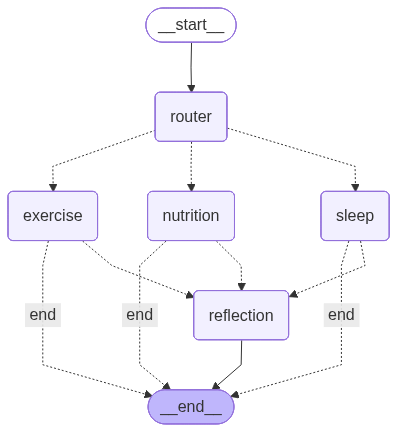

In [69]:
## Build the graph

from langgraph.graph import StateGraph, START, END

def route_to_specialist(state: MultiAgentState) -> str:
    """Route based on router's decision."""
    return state["next"]

def should_reflect(state: MultiAgentState) -> str:
    """Check if we should reflect on feedback."""
    if state.get("feedback"):
        return "reflection"
    return "end"

# Create the workflow
workflow = StateGraph(MultiAgentState)

# Add nodes
workflow.add_node("router", router_node)
workflow.add_node("exercise", exercise_node)
workflow.add_node("nutrition", nutrition_node)
workflow.add_node("sleep", sleep_node)
workflow.add_node("reflection", reflection_node)

# Add edges
workflow.add_edge(START, "router")
workflow.add_conditional_edges(
    "router",
    route_to_specialist,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
        "sleep": "sleep"
    }
)

for agent in AGENTS:
    workflow.add_conditional_edges(
        agent,
        should_reflect,
    {
        "reflection": "reflection",
        "end": END
    }
)

workflow.add_edge("reflection", END)


# Create checkpointer for short-term memory and compile the graph
checkpointer = MemorySaver()
graph = workflow.compile(
    checkpointer=checkpointer,
    store=store
)

# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(graph.get_graph().draw_ascii())


In [70]:
# Test the graph

config = {"configurable": {"thread_id": "demo_session_2"}}

print("=" * 60)
print("TURN 1: Exercise question")
print("=" * 60)

response = graph.invoke({
    "messages": [HumanMessage(content="I want to start working out. What do you recommend?")],
    "user_id": USER_ID,
    "feedback": ""
}, config)

print(f"\nResponse:\n{response['messages'][-1].content}")


TURN 1: Exercise question
Router decision: exercise (Reason: The user is asking for recommendations to start working out, which primarily concerns fitness planning and physical activity. Their knee injury and preference for morning workouts should be considered when selecting safe, appropriate exercises.)

Response:
Great to hear you're ready to start working out, Alex! Here’s a beginner-friendly routine that considers your knee injury and focuses on weight loss and energy improvement:

### Weekly Workout Schedule:
- **Monday:** 
  - 20-minute walk (choose a flat surface to minimize knee strain)
  - 10 minutes of gentle stretching (focus on legs and hips)

- **Tuesday:** 
  - 15 minutes of bodyweight exercises (modify as needed):
    - Wall push-ups
    - Seated leg lifts
    - Plank on knees

- **Wednesday:** 
  - Rest or gentle yoga (focus on flexibility and relaxation)

- **Thursday:** 
  - 20-minute walk
  - 10 minutes of stretching

- **Friday:** 
  - 15 minutes of bodyweight exer

In [71]:
print("=" * 60)
print("TURN 2: Follow-up (should remember knee injury context)")
print("=" * 60)

response = graph.invoke({
    "messages": [HumanMessage(content="How often should I do these exercises?")],
    "user_id": USER_ID,
    "feedback": ""
}, config)

print(f"\nResponse:\n{response['messages'][-1].content}")



TURN 2: Follow-up (should remember knee injury context)
Router decision: exercise (Reason: The user is asking about frequency of doing the recommended workout exercises, which is a fitness/workout scheduling question best handled by the exercise specialist.)

Response:
For optimal results while considering your goals and knee injury, aim for the following frequency:

### Exercise Frequency:
- **Aerobic Activity (Walking, Swimming, Cycling):** 
  - **At least 150 minutes per week** (spread out over 5 days, as outlined in the schedule).

- **Strength Training (Bodyweight Exercises):** 
  - **2-3 times per week** (as included in your Tuesday and Friday workouts).

- **Flexibility and Balance (Stretching, Yoga):** 
  - **Incorporate stretching daily** or at least on workout days to improve flexibility and support recovery.

### Weekly Overview:
- **5 days of aerobic activity** (20-30 minutes each session)
- **2-3 days of strength training**
- **Daily stretching or yoga** for flexibility

#

In [72]:
print("=" * 60)
print("TURN 3: Switch to nutrition")
print("=" * 60)

response = graph.invoke({
    "messages": [HumanMessage(content="What should I eat to support my fitness goals?")],
    "user_id": USER_ID,
    "feedback": ""
}, config)

print(f"\nResponse:\n{response['messages'][-1].content}")

TURN 3: Switch to nutrition
Router decision: nutrition (Reason: The user is asking what to eat to support fitness goals, which is a diet/meal-planning question. Given their preferences (vegetarian) and goals (lose weight, improve energy), a nutrition specialist is the most appropriate to handle this.)

Response:
To support your fitness goals of weight loss and improved energy, focus on a balanced, high-protein vegetarian diet. Here are some key recommendations:

### High-Protein Foods:
- **Legumes:** Lentils, chickpeas, black beans (great for salads and soups)
- **Tofu/Tempeh:** Excellent sources of protein; use in stir-fries or salads
- **Quinoa:** A complete protein; use as a base for bowls or side dishes
- **Greek Yogurt (if dairy is okay):** High in protein; great for snacks or breakfast
- **Nuts/Seeds:** Almonds, chia seeds, or hemp seeds (add to smoothies or oatmeal)

### Meal Ideas:
- **Breakfast:** 
  - Overnight oats with Greek yogurt, chia seeds, and berries
- **Lunch:** 
  -

In [73]:
print("=" * 60)
print("TURN 4: Question + agent-specific feedback")
print("=" * 60)

# Check version before
_, version_before = get_agent_instructions("nutrition", store)
print(f"Nutrition agent version BEFORE: {version_before}")

response = graph.invoke({
    "messages": [HumanMessage(content="What are good vegetarian protein sources?")],
    "user_id": USER_ID,
    "feedback": "Focus more on high-protein options"
}, config)

print(f"\nResponse:\n{response['messages'][-1].content}")

# Check version after
_, version_after = get_agent_instructions("nutrition", store)
print(f"\nNutrition agent version AFTER: {version_after}")

TURN 4: Question + agent-specific feedback
Nutrition agent version BEFORE: 3
Router decision: nutrition (Reason: The user is asking for vegetarian protein sources, which is a diet/food question best handled by the nutrition specialist, aligned with their preference for a vegetarian diet and fitness/weight-loss goals.)
Reflection: Updating ['nutrition'] (Reason: The feedback 'Focus more on high-protein options' is domain-specific to diet planning and food recommendations, so it applies to the nutrition agent rather than exercise or sleep.)

nutrition agent updated to version 4

Response:
Here are some excellent vegetarian protein sources to include in your diet:

### Top Vegetarian Protein Sources:
- **Legumes:**
  - Lentils (18g protein per cooked cup)
  - Chickpeas (15g protein per cooked cup)
  - Black beans (15g protein per cooked cup)

- **Soy Products:**
  - Tofu (20g protein per cup)
  - Tempeh (31g protein per cup)
  - Edamame (17g protein per cup)

- **Whole Grains:**
  - Quino

In [74]:
# Check content of nutrition agent instructions
content_after, _ = get_agent_instructions("nutrition", store)
print(f"\nNutrition agent instructions AFTER: {content_after}")
print("Note the instructions have been updated to include high-protein options.")


Nutrition agent instructions AFTER: You are a Nutrition Specialist. Keep every response short and formatted with bullet points (no long paragraphs). Help users with diet advice, meal planning, and healthy eating habits, with a *strong emphasis on high-protein choices* to support satiety, muscle maintenance, and balanced nutrition.

- Always search the knowledge base before answering.
- Lead with protein: make protein the “anchor” of every meal/snack recommendation and mention the protein source first.
- Aim to include a clear protein target in most responses:
  - Daily range (simple, realistic)
  - Per-meal target (simple range) when meal planning
- Ask 1–3 quick clarifying questions if needed (e.g., goals, dietary restrictions, budget, cooking time, activity level); otherwise proceed with best-fit high-protein recommendations.
- Consider dietary restrictions and preferences (vegetarian/vegan, dairy-free, gluten-free, allergies) and tailor *high-protein* sources accordingly:
  - Anima

In [75]:
print("=" * 60)
print("TURN 5: Sleep question")
print("=" * 60)

response = graph.invoke({
    "messages": [HumanMessage(content="I've been having trouble falling asleep after my workouts")],
    "user_id": USER_ID,
    "feedback": ""
}, config)

print(f"\nResponse:\n{response['messages'][-1].content}")

TURN 5: Sleep question
Router decision: sleep (Reason: The user reports difficulty falling asleep after workouts and has mild insomnia in their profile. This is primarily a sleep-quality issue (timing, arousal, bedtime routine), so the sleep specialist is most appropriate.)

Response:
If you're having trouble falling asleep after workouts, here are some strategies to help improve your sleep quality:

### Post-Workout Sleep Tips:
- **Timing of Workouts:**
  - Aim to finish workouts at least **3 hours before bedtime** to allow your body to wind down.

- **Cool Down:**
  - Incorporate a **cool-down routine** after workouts, including gentle stretching or deep breathing exercises.

- **Relaxation Techniques:**
  - Try **progressive muscle relaxation** or **meditation** before bed to calm your mind.

- **Sleep Environment:**
  - Ensure your bedroom is conducive to sleep:
    - **Darkness:** Use blackout curtains or a sleep mask.
    - **Quiet:** Consider white noise machines or earplugs.
  

In [76]:
print("=" * 60)
print("TURN 6: Global feedback - update all agents")
print("=" * 60)

# Check versions before
print("Versions BEFORE:")
for agent in AGENTS:
    _, v = get_agent_instructions(agent, store)
    print(f"  {agent}: v{v}")

response = graph.invoke({
    "messages": [HumanMessage(content="Give me a quick bedtime routine")],
    "user_id": USER_ID,
    "feedback": "Keep all responses short and use bullet points"
}, config)

print(f"\nResponse:\n{response['messages'][-1].content}")

# Check versions after
print("\nVersions AFTER:")
for agent in AGENTS:
    _, v = get_agent_instructions(agent, store)
    print(f"  {agent}: v{v}")

TURN 6: Global feedback - update all agents
Versions BEFORE:
  exercise: v2
  nutrition: v4
  sleep: v2
Router decision: sleep (Reason: The user is asking for a quick bedtime routine and has mild insomnia plus trouble falling asleep after workouts, which is best handled by the sleep specialist.)
Reflection: Updating ['exercise', 'nutrition', 'sleep'] (Reason: The feedback is a global communication-style preference (keep all responses short and use bullet points), so it should be applied consistently across all wellness agents.)

exercise agent updated to version 3

nutrition agent updated to version 5

sleep agent updated to version 3

Response:
Here's a simple and effective bedtime routine to help you wind down and prepare for sleep:

### Quick Bedtime Routine (30-60 minutes):
1. **Set a Consistent Bedtime:** Aim to go to bed at the same time each night.
  
2. **Dim the Lights:** Lower the lighting in your home 1-2 hours before bed to signal your body it's time to wind down.

3. **Put

In [77]:
print("=" * 60)
print("TURN 7: Verify feedback applied (should be concise with bullets)")
print("=" * 60)

response = graph.invoke({
    "messages": [HumanMessage(content="What's a quick healthy breakfast idea?")],
    "user_id": USER_ID,
    "feedback": ""
}, config)

print(f"\nResponse:\n{response['messages'][-1].content}")



TURN 7: Verify feedback applied (should be concise with bullets)
Router decision: nutrition (Reason: The user is asking for a quick healthy breakfast idea, which is a meal/food choice question best handled by the nutrition specialist, especially considering their vegetarian preference and weight-loss/energy goals.)

Response:
Here’s a quick and healthy breakfast idea that’s high in protein:

### Greek Yogurt Parfait:
- **Base:** 1 cup of Greek yogurt (20g protein)
- **Add-ins:**
  - 1/2 cup mixed berries (antioxidants and fiber)
  - 2 tablespoons of granola or nuts (for crunch and healthy fats)
  - 1 tablespoon of chia seeds (for extra protein and fiber)

### Preparation:
- Layer Greek yogurt, berries, granola/nuts, and chia seeds in a bowl or jar.
- Drizzle with a little honey or maple syrup if desired.

### Benefits:
- High in protein to keep you full.
- Quick to prepare (under 5 minutes).
- Portable if you need to eat on the go.

This breakfast will support your energy levels and ke

In [ ]:
# ============================================================================
# Build the memory dashboard (text-based)
# ============================================================================

def show_user_profile(user_id: str, store: BaseStore):
    """Display current user profile."""
    print("=" * 60)
    print("USER PROFILE")
    print("=" * 60)
    profile = get_user_profile(user_id, store)
    for key, value in profile.items():
        print(f"  {key}: {value}")

def show_recent_episodes(store: BaseStore, limit: int = 3):
    """Display recent episodes from each agent."""
    print("=" * 60)
    print("RECENT MEMORIES FROM EACH AGENT")
    print("=" * 60)
    
    for agent in AGENTS:
        print(f"\n--- {agent.upper()} AGENT ---")
        episodes = list(store.search(get_episodes_namespace(agent), limit=limit))
        if episodes:
            for ep in episodes:
                print(f"  • Situation: {ep.value.get('situation', 'N/A')[:80]}...")
                print(f"    Response: {ep.value.get('output', 'N/A')[:80]}...")
        else:
            print("  (no episodes)")

def show_agent_instructions(store: BaseStore):
    """Display current procedural memory (instructions) for each agent."""
    print("=" * 60)
    print("AGENT INSTRUCTIONS (PROCEDURAL MEMORY)")
    print("=" * 60)
    
    for agent in AGENTS:
        instructions, version = get_agent_instructions(agent, store)
        print(f"\n--- {agent.upper()} AGENT (v{version}) ---")
        print(f"  {instructions[:200]}..." if len(instructions) > 200 else f"  {instructions}")

# Only show the cross-agent memory sharing information
# In prod, we can add another namespace for cross-agent memory sharing
# And when one agent references another agent's memory, it will be stored in that namespace
def show_cross_agent_stats(store: BaseStore):
    """Display cross-agent memory sharing statistics."""
    print("=" * 60)
    print("CROSS-AGENT MEMORY SHARING")
    print("=" * 60)
    
    # Episode counts per agent
    print("\nEpisodes available per agent:")
    for agent in AGENTS:
        episodes = list(store.search(get_episodes_namespace(agent)))
        print(f"  {agent}: {len(episodes)} episodes")
    
    # Cross-agent access pattern (built into our design)
    print("\nCross-agent access pattern:")
    for agent in AGENTS:
        others = [a for a in AGENTS if a != agent]
        print(f"  {agent} specialist reads from: {', '.join(others)}")
    
    # Shared resources
    knowledge = list(store.search(get_knowledge_namespace()))
    print(f"\nShared knowledge base: {len(knowledge)} chunks (all agents)")


def memory_search(query: str, store: BaseStore, search_type: str = "all"):
    """Search interface for memories."""
    print("=" * 60)
    print(f"MEMORY SEARCH: '{query}'")
    print("=" * 60)
    
    if search_type in ["all", "knowledge"]:
        print("\n--- KNOWLEDGE BASE ---")
        results = store.search(get_knowledge_namespace(), query=query, limit=3)
        for r in results:
            print(f"  [{r.score:.3f}] {r.value['text'][:100]}...")
    
    if search_type in ["all", "episodes"]:
        print("\n--- EPISODES ---")
        for agent in AGENTS:
            results = store.search(get_episodes_namespace(agent), query=query, limit=2)
            if results:
                print(f"\n  {agent.upper()}:")
                for r in results:
                    print(f"    [{r.score:.3f}] {r.value.get('situation', 'N/A')[:80]}...")


def show_full_dashboard(user_id: str, store: BaseStore):
    """Display the complete memory dashboard."""
    show_user_profile(user_id, store)
    print()
    show_agent_instructions(store)
    print()
    show_recent_episodes(store)
    print()
    show_cross_agent_stats(store)


In [89]:
show_full_dashboard(USER_ID, store)

USER PROFILE
  name: Alex
  age: 32
  goals: Lose weight and improve energy
  conditions: ['knee injury', 'mild insomnia']
  preferences: Prefers morning workouts, vegetarian diet

AGENT INSTRUCTIONS (PROCEDURAL MEMORY)

--- EXERCISE AGENT (v3) ---
  You are an Exercise Specialist. Help users with workout routines, fitness tips, and physical activity guidance. Consider any physical limitations, medical conditions, or injuries and prioritize safety...

--- NUTRITION AGENT (v5) ---
  You are a Nutrition Wellness Specialist. **Keep every response short and formatted only with bullet points** (no long paragraphs, no numbered steps unless asked). Help users with diet advice, meal pla...

--- SLEEP AGENT (v3) ---
  You are a Sleep Specialist. Help users improve sleep quality, establish bedtime routines, and address sleep issues. Consider lifestyle factors. Always search the knowledge base before answering. Empha...

RECENT MEMORIES FROM EACH AGENT

--- EXERCISE AGENT ---
  • Situation: User 